# Assignment: Data Wrangling
### `! git clone https://github.com/ds3001f25/wrangling_assignment.git`
### Do Q1 and Q2
### Reading material: `tidy_data.pdf`

**Q1.** This question provides some practice cleaning variables which have common problems.
1. Numeric variable: For `./data/airbnb_hw.csv`, clean the `Price` variable as well as you can, and explain the choices you make. How many missing values do you end up with? (Hint: What happens to the formatting when a price goes over 999 dollars, say from 675 to 1,112?)
2. Categorical variable: For the Minnesota police use of for data, `./data/mn_police_use_of_force.csv`, clean the `subject_injury` variable, handling the NA's; this gives a value `Yes` when a person was injured by police, and `No` when no injury occurred. What proportion of the values are missing? Is this a concern? Cross-tabulate your cleaned `subject_injury` variable with the `force_type` variable. Are there any patterns regarding when the data are missing? 
3. Dummy variable: For the pretrial data covered in the lecture `./data/justice_data.parquet`, clean the `WhetherDefendantWasReleasedPretrial` variable as well as you can, and, in particular, replace missing values with `np.nan`.
4. Missing values, not at random: For the pretrial data covered in the lecture, clean the `ImposedSentenceAllChargeInContactEvent` variable as well as you can, and explain the choices you make. (Hint: Look at the `SentenceTypeAllChargesAtConvictionInContactEvent` variable.)

In [29]:
import pandas as pd
import numpy as np
airbnb = pd.read_csv("./data/airbnb_hw.csv")

# 1

# Remove $ and commas, convert to numeric
airbnb['Price_clean'] = (
    airbnb['Price']
    .astype(str)
    .str.replace(r'[\$,]', '', regex=True)  # remove $ and commas
    .str.strip()
)

airbnb['Price_clean'] = pd.to_numeric(airbnb['Price_clean'], errors='coerce')

print(f"Missing values in Price_clean: {airbnb['Price_clean'].isna().sum()}")

# 2

police = pd.read_csv("./data/mn_police_use_of_force.csv")

police['subject_injury_clean'] = (
    police['subject_injury']
    .astype(str).str.strip().str.lower()
    .replace({
        'yes': 'Yes',
        'no': 'No',
        'nan': pd.NA,  # true NaNs
        '': pd.NA
    })
)

# --- Proportion of missing values ---
prop_missing = police['subject_injury_clean'].isna().mean()
print(f"Proportion missing in subject_injury: {prop_missing:.2%}")

# --- Cross-tab with force_type ---
crosstab = pd.crosstab(police['subject_injury_clean'], 
                       police['force_type'], 
                       dropna=False)

print(crosstab)

# 3
justice = pd.read_parquet("./data/justice_data.parquet")

justice['ReleasedPretrial_clean'] = (
    justice['WhetherDefendantWasReleasedPretrial']
    .astype(str).str.strip().str.lower()
    .replace({
        'yes': 1, 'y': 1, 'released': 1, '1': 1,
        'no': 0, 'n': 0, 'not released': 0, '0': 0,
        'nan': np.nan, '': np.nan,
    })
)

justice['ReleasedPretrial_clean'] = pd.to_numeric(
    justice['ReleasedPretrial_clean'], errors='coerce'
)

# 4

justice['ImposedSentenceAllChargeInContactEvent'].value_counts(dropna=False)
justice['SentenceTypeAllChargesAtConvictionInContactEvent'].value_counts(dropna=False)

justice['imposed_sentence_clean'] = pd.to_numeric(
    justice['ImposedSentenceAllChargeInContactEvent'], errors='coerce'
)

# Keep missing values as np.nan
missing_count = justice['imposed_sentence_clean'].isna().mean()
print(f"Missing values: {missing_count} ({missing_count:.2%})")


Missing values in Price_clean: 0
Proportion missing in subject_injury: 76.19%
force_type            Baton  Bodily Force  Chemical Irritant  Firearm  \
subject_injury_clean                                                    
No                        0          1093                131        2   
Yes                       2          1286                 41        0   
NaN                       2          7051               1421        0   

force_type            Gun Point Display  Improvised Weapon  Less Lethal  \
subject_injury_clean                                                      
No                                   33                 34            0   
Yes                                  44                 40            0   
NaN                                  27                 74           87   

force_type            Less Lethal Projectile  Maximal Restraint Technique  \
subject_injury_clean                                                        
No                        

1. For cleaning the data, I removed the '$' and ',' symbols, as those are commonly found in numbers. This avoids the issue when price goes from 675 to 1,112, as it is getting rid of the comma. There were 0 missing values after the cleaning.

2. The proportion of missing values is 76.19%, which is really high and is a concern. Cross-tabbing with force-type, we can see that there are patterns with force-type, and that certain categories such as Less Lethal Projectile and Maximal Restraint Technique have all null values, while most of Taser is null as well. This suggests that the injury reporting for subject_injury was systematic, with certain force types such as Less Lethal Projectile and Maximal Restraint Technique not including the field at all. Its possible that these categories weren't required to report subject_inquiry, although over 75% of the records for subject_injury being missing is still concerning.

3. After cleaning the 'WhetherDefendantWasReleasedPretrial' variable and replacing all the missing values with np.nan, we can see that 19154 people were released pretrial, 3801 weren't, and 31 enteries were missing.

4. To clean the ImposedSentenceAllChargeInContactEvent variable, I cleaned the variable by converting all valid numeric sentence values into numbers and coercing anything non-numeric (like text codes or blanks) into NaN. I then chose to leave the missing values as NaN instead of imputing them, since they aren't random, and they correspond to sentence types where no numeric length applies. This way, the cleaned column is usable for analysis while still preserving the informative pattern of missingness.

**Q2.** Go to https://sharkattackfile.net/ and download their dataset on shark attacks (Hint: `GSAF5.xls`).

1. Open the shark attack file using Pandas. It is probably not a csv file, so `read_csv` won't work.
2. Drop any columns that do not contain data.
3. Clean the year variable. Describe the range of values you see. Filter the rows to focus on attacks since 1940. Are attacks increasing, decreasing, or remaining constant over time?
4. Clean the Age variable and make a histogram of the ages of the victims.
5. What proportion of victims are male?
6. Clean the `Type` variable so it only takes three values: Provoked and Unprovoked and Unknown. What proportion of attacks are unprovoked?
7. Clean the `Fatal Y/N` variable so it only takes three values: Y, N, and Unknown.
8. Are sharks more likely to launch unprovoked attacks on men or women? Is the attack more or less likely to be fatal when the attack is provoked or unprovoked? Is it more or less likely to be fatal when the victim is male or female? How do you feel about sharks?
9. What proportion of attacks appear to be by white sharks? (Hint: `str.split()` makes a vector of text values into a list of lists, split by spaces.)

0.0 2026.0


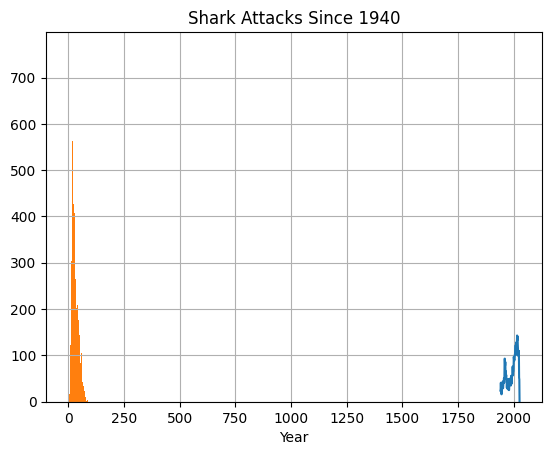

In [ ]:
import pandas as pd

df = pd.read_excel("./data/GSAF5.xls")

# Drop columns that do not contain any data
df = df.dropna(axis=1, how="all")

# Clean 'Year' column
df['Year'] = pd.to_numeric(df['Year'], errors='coerce')
print(df['Year'].min(), df['Year'].max()) # Range of values

# Focus on attacks since 1940
df_recent = df[df['Year'] >= 1940]

# Count attacks per year
attacks_per_year = df_recent.groupby('Year').size()
attacks_per_year.plot(kind='line', title="Shark Attacks Since 1940")

# Clean 'Age' column and plot histogram
df['Age'] = pd.to_numeric(df['Age'], errors='coerce')
df['Age'].dropna().hist(bins=20)

# Propotion of male victims
df['Sex'] = df['Sex'].str.upper().str.strip()
prop_male = (df['Sex'] == 'M').mean()

# Clean 'Type' column and calculate proportion of unprovoked attacks
def clean_type(x):
    if isinstance(x, str):
        if "PROVOKED" in x.upper():
            return "Provoked"
        elif "UNPROVOKED" in x.upper():
            return "Unprovoked"
    return "Unknown"

df['Type_Clean'] = df['Type'].apply(clean_type)
prop_unprovoked = (df['Type_Clean'] == "Unprovoked").mean()

# Clean 'Fatal Y/N' column
def clean_fatal(x):
    if x in ['Y', 'N']:
        return x
    return "Unknown"

df['Fatal_Clean'] = df['Fatal Y/N'].apply(clean_fatal)


# 8
pd.crosstab(df['Sex'], df['Type_Clean'], normalize='index')
pd.crosstab(df['Type_Clean'], df['Fatal_Clean'], normalize='index')
pd.crosstab(df['Sex'], df['Fatal_Clean'], normalize='index')

# 9
df['Species '] = df['Species '].fillna("").str.upper()
white_shark = df['Species '].str.contains("WHITE", na=False)
prop_white = white_shark.mean()

